Imports

In [12]:
import sklearn

import numpy as np
import pandas as pd

# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle


# plot
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


Dataset

In [2]:
train = pd.read_csv('../data/train_balnced_no_test.csv')
test = pd.read_csv('../data/test_umbalanced.csv')

In [3]:
# removing unwanted features
train = train.drop(['status_RESOLVED', 'status_VERIFIED', 'changes_status', 'changes_resolution'], axis=1)
test = test.drop(['status_RESOLVED', 'status_VERIFIED', 'changes_status', 'changes_resolution'], axis=1)

In [ ]:
train.head()

,bg_number,total_users_commenting,total_comments_by_author,has_attachment,total_attachment_comments,changes_severity,changes_priority,changes_assigned,total_changes,total_users_changes,...,op_sys_OpenBSD,op_sys_OpenSolaris,op_sys_Other,op_sys_Solaris,op_sys_Unspecified,op_sys_Windows,op_sys_Windows Phone 8,op_sys_iOS,op_sys_macOS,label
0,830663.0,1,0,False,0,1,0,0,3,1,...,0,0,0,0,0,1,0,0,0,INCOMPLETE
1,1435530.0,10,0,False,9,0,1,1,24,10,...,0,0,0,0,1,0,0,0,0,FIXED
2,858085.0,1,1,False,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,DUPLICATE
3,1596186.0,2,1,False,1,0,1,0,4,2,...,0,0,0,0,0,0,0,0,0,FIXED
4,1290302.0,1,3,True,2,0,3,1,13,2,...,0,0,0,0,0,0,0,1,0,FIXED


In [ ]:
len(train.columns)

1224

Functions

In [4]:
def get_data(path):
    return [pd.read_csv(path + "train.csv"), pd.read_csv(path + "test.csv")]


def show_distribution_graph(df):
    df = df['label'].value_counts().to_frame()
    df = df.reset_index().rename(columns={"index": "Resolution", "label": "Total"})

    return alt.Chart(df).mark_bar().encode(
        x=alt.X('Resolution', sort='-y'),
        y='Total',
        color = alt.value("#ac97b4")
    )

def print_metrics(model, model_name, metrics, x_test, y_test, classes):
    print(f"{model_name} Metrics:\n")
    for i in range(4):
        print(f"{metrics['Metrics'][i]} score is:\t{round(metrics['Scores'][i] * 100,2)}%")
    print("\n")

    confusion_matrix = plot_confusion_matrix(model, x_test, y_test, labels=classes, cmap=plt.cm.Blues, xticks_rotation = "vertical")

    return confusion_matrix

def compute_metrics(pred, y_test):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')

    return {"Metrics": ["Accuracy", "Precision", "Recall", "F1"], "Scores": [accuracy, precision, recall, f1]}


def compute_metrics_per_class(pred, y_test):

    # Print the confusion matrix
    print(metrics.confusion_matrix(y_test, pred))

    # Print the precision and recall, among other metrics
    print(metrics.classification_report(y_test, pred, digits=2))

def get_metrics(model, model_name, x_train, y_train, x_test, y_test, classes):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    metrics = compute_metrics(pred,  y_test)
    print_metrics(model, model_name, metrics, x_test, y_test, classes)
    compute_metrics_per_class(pred, y_test)

    return metrics['Scores']


def get_metric_data(models, models_names):
    # models: [NB_metrics,LG_metrics,DT_metrics,RF_metrics, GB_metrics]
    # TODO: fix this method
    metrics = np.array(models).flatten()
    metrics = list(map(lambda x: x*100, metrics))

    data = {"Metric":
            ['Accuracy', 'Precision', 'Recall', 'F1 Score'] * 5,
            "Metric Score": metrics,
            "Model":
            ['Naive Bayes'] * 4 +
            ['Logistic Regression'] * 4 +
            ['Decision Tree'] * 4 +
            ['Random Forest'] * 4 +
            ['Gradient Boosting'] * 4
        }

    return pd.DataFrame(data)


def plot_metric_graph(data):
    g = sns.catplot(
        data=data,
        kind="bar", x="Metric", y="Metric Score", hue="Model",
        ci="sd", alpha=.6, height=6
    )
    g.set(ylim=(0, 100))
    g.despine(left=True)


def get_params(model_name):
    if (model_name == "Logistic Regression"):
        return { 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0] }
    elif (model_name == "Gradient Boosting"):
        return {
            'n_estimators': [50, 100],
            'max_depth': [3, 8],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 5],
            'max_features': [None, 5],
            'subsample': [0.5, 1]
            }
    else:
        return { 'max_depth': [None, 15, 35, 50], 'max_leaf_nodes': [None, 250, 500, 750, 1000, 5000]}

def print_best_params(model_name, grid, folds):
    print(f'Hyperparams of {model_name}:\n')
    print(f'Got accuracy score of {grid.best_score_} in {folds}-fold')
    if (model_name == "Logistic Regression"):
        print(f'Best C: {grid.best_params_["C"]}')
    elif (model_name == "Gradient Boosting"):
        print(f'Best max depth: {grid.best_params_["max_depth"]}. Best number of estimators: {grid.best_params_["n_estimators"]}')
        print(f'Best min sample split: {grid.best_params_["min_samples_split"]}. Best min sample leaf: {grid.best_params_["min_samples_leaf"]}')
        print(f'Best max features: {grid.best_params_["max_features"]}. Best subsample: {grid.best_params_["subsample"]}')
    else:
        print(f'Best depth: {grid.best_params_["max_depth"]}. Best number of leafs: {grid.best_params_["max_leaf_nodes"]}')

def get_tuned_metrics(model, model_name, folds, x_train, y_train, x_test, y_test, classes):
    params = get_params(model_name)

    grid = GridSearchCV(model, params, cv = folds)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)

    print_best_params(model_name, grid, folds)
    metrics = compute_metrics(pred, y_test)
    print_metrics(grid, model_name, metrics, x_test, y_test, classes)
    return metrics['Scores'], pred

Data Analysis

In [ ]:
show_distribution_graph(train)

alt.Chart(...)

In [ ]:
show_distribution_graph(test)

alt.Chart(...)

Normalization

In [ ]:
scaler = StandardScaler()
#transformed = scaler.fit_transform(train.drop(['label'], axis=1))
#transformed_df = pd.DataFrame(transformed)
#transformed_df.head()

Classification

In [5]:
x_train = train.drop('label', axis=1)
x_test = test.drop('label', axis=1)
y_train = train['label']
y_test = test['label']
classes = train['label'].unique()

In [6]:
# models

NB = GaussianNB()
LG = LogisticRegression(max_iter=5000)
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(random_state=42)
GB = GradientBoostingClassifier(random_state=0)

Naive Bayes

Naive Bayes Metrics:

Accuracy score is:	12.35%
Precision score is:	66.04%
Recall score is:	12.35%
F1 score is:	14.11%




/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[ 279   12    8   30    1  341  636    3]
 [1038  813  225   77    4 3198 3108   25]
 [   9    0    0    1    0    8   22    2]
 [ 269    5    1   22    0   56  350    9]
 [  88    3    1    6    0   79  273    2]
 [   0    0    0    0    0    7    0    0]
 [ 133    8    3    6    0   80  495    3]
 [ 367   18   11   50    3  243  756   15]]
              precision    recall  f1-score   support

   DUPLICATE       0.13      0.21      0.16      1310
       FIXED       0.95      0.10      0.17      8488
    INACTIVE       0.00      0.00      0.00        42
  INCOMPLETE       0.11      0.03      0.05       712
     INVALID       0.00      0.00      0.00       452
       MOVED       0.00      1.00      0.00         7
     WONTFIX       0.09      0.68      0.16       728
  WORKSFORME       0.25      0.01      0.02      1463

    accuracy                           0.12     13202
   macro avg       0.19      0.25      0.07     13202
weighted avg       0.66      0.12      0.14     13202



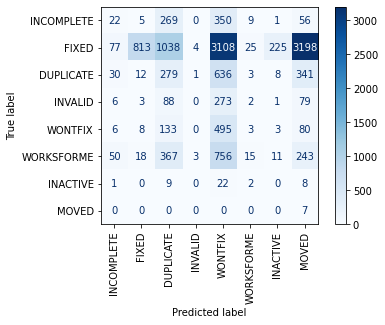

In [ ]:
NB_metrics = get_metrics(NB, "Naive Bayes", x_train, y_train, x_test, y_test, classes)

Logistic Regression

/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Metrics:

Accuracy score is:	0.05%
Precision score is:	0.0%
Recall score is:	0.05%
F1 score is:	0.0%


[[   0    0    0    0    0 1310    0    0]
 [   0    0    0    0    0 8488    0    0]
 [   0    0    0    0    0   42    0    0]
 [   0    0    0    0    0  712    0    0]
 [   0    0    0    0    0  452    0    0]
 [   0    0    0    0    0    7    0    0]
 [   0    0    0    0    0  728    0    0]
 [   0    0    0    0    0 1463    0    0]]
              precision    recall  f1-score   support

   DUPLICATE       0.00      0.00      0.00      1310
       FIXED       0.00      0.00      0.00      8488
    INACTIVE       0.00      0.00      0.00        42
  INCOMPLETE       0.00      0.00      0.00       712
     INVALID       0.00      0.00      0.00       452
       MOVED       0.00      1.00      0.00         7
     WONTFIX       0.00      0.00      0.00       728
  WORKSFORME       0.00      0.00      0.00      1463

    accuracy                           0.00 

/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


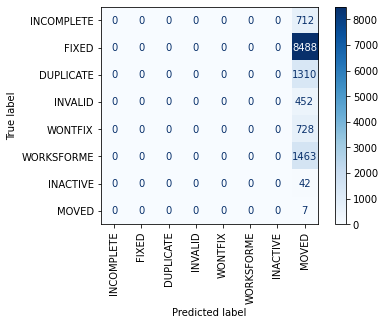

In [ ]:
LG_metrics = get_metrics(LG, "Logistic Regression", x_train, y_train, x_test, y_test, classes)

Decision Tree

Decision Tree Metrics:

Accuracy score is:	65.66%
Precision score is:	66.35%
Recall score is:	65.66%
F1 score is:	66.0%


[[ 365  357   10   96   92    6  108  276]
 [ 398 7267   14  105  145    7  204  348]
 [   7   11    2    3    3    0    3   13]
 [ 108   97    5  293   30    1   53  125]
 [  91   96    5   35   83    0   48   94]
 [   3    2    0    0    1    0    0    1]
 [ 117  198   10   37   58    1  196  111]
 [ 290  340   15  127  102    4  122  463]]


/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

   DUPLICATE       0.26      0.28      0.27      1310
       FIXED       0.87      0.86      0.86      8488
    INACTIVE       0.03      0.05      0.04        42
  INCOMPLETE       0.42      0.41      0.42       712
     INVALID       0.16      0.18      0.17       452
       MOVED       0.00      0.00      0.00         7
     WONTFIX       0.27      0.27      0.27       728
  WORKSFORME       0.32      0.32      0.32      1463

    accuracy                           0.66     13202
   macro avg       0.29      0.30      0.29     13202
weighted avg       0.66      0.66      0.66     13202



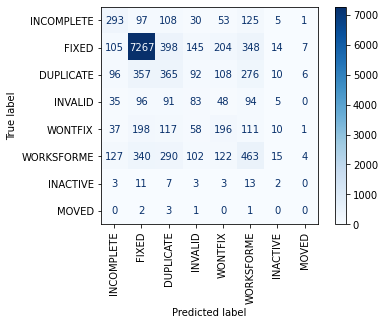

In [ ]:
DT_metrics = get_metrics(DT, "Decision Tree", x_train, y_train, x_test, y_test, classes)

# Random Forest

/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Metrics:

Accuracy score is:	74.46%
Precision score is:	71.81%
Recall score is:	74.46%
F1 score is:	72.32%


[[ 456  485    0   44   25    0   54  246]
 [ 161 8101    0   19   13    0   44  150]
 [   5   15    1    2    1    0    2   16]
 [  82  107    0  334    8    0   25  156]
 [ 106  132    0   13   75    0   24  102]
 [   3    2    0    0    0    0    0    2]
 [  96  261    0   18    9    0  218  126]
 [ 233  432    1   70   18    0   64  645]]


/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookproz/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

              precision    recall  f1-score   support

   DUPLICATE       0.40      0.35      0.37      1310
       FIXED       0.85      0.95      0.90      8488
    INACTIVE       0.50      0.02      0.05        42
  INCOMPLETE       0.67      0.47      0.55       712
     INVALID       0.50      0.17      0.25       452
       MOVED       0.00      0.00      0.00         7
     WONTFIX       0.51      0.30      0.38       728
  WORKSFORME       0.45      0.44      0.44      1463

    accuracy                           0.74     13202
   macro avg       0.48      0.34      0.37     13202
weighted avg       0.72      0.74      0.72     13202



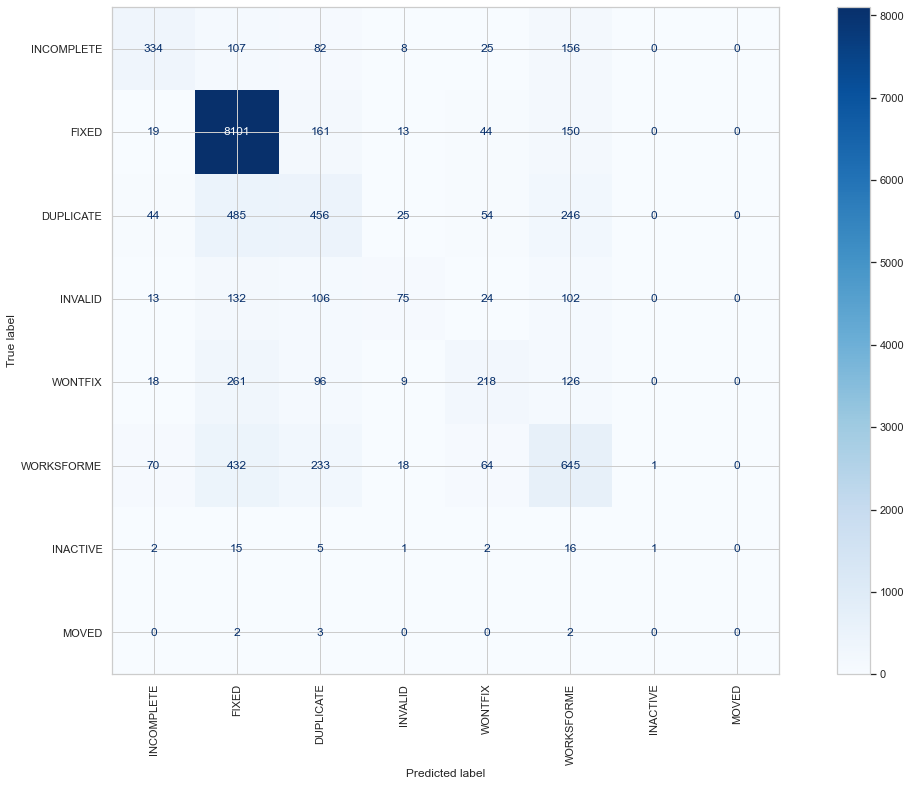

In [13]:
RF_metrics = get_metrics(RF, "Random Forest", x_train, y_train, x_test, y_test, classes)

Gradient Boosting

Gradient Boosting Metrics:

Accuracy score is:	65.79%
Precision score is:	73.28%
Recall score is:	65.79%
F1 score is:	68.85%




/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[ 448  127   46  122  167   50  158  192]
 [ 479 6872   73   98  217   97  398  254]
 [   3    2   19    3    3    1    3    8]
 [  63   17   18  387   42    6   74  105]
 [  85   23   13   58  147   11   61   54]
 [   2    1    0    0    0    4    0    0]
 [  89   57   46   52   60    8  314  102]
 [ 274  116   67  214  130   35  133  494]]
              precision    recall  f1-score   support

   DUPLICATE       0.31      0.34      0.33      1310
       FIXED       0.95      0.81      0.88      8488
    INACTIVE       0.07      0.45      0.12        42
  INCOMPLETE       0.41      0.54      0.47       712
     INVALID       0.19      0.33      0.24       452
       MOVED       0.02      0.57      0.04         7
     WONTFIX       0.28      0.43      0.34       728
  WORKSFORME       0.41      0.34      0.37      1463

    accuracy                           0.66     13202
   macro avg       0.33      0.48      0.35     13202
weighted avg       0.73      0.66      0.69     13202



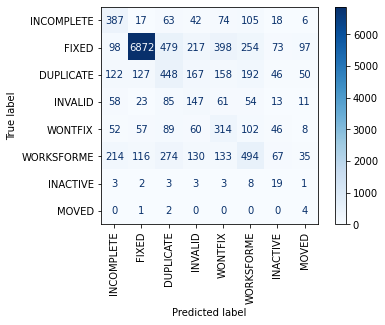

In [ ]:
GB_metrics = get_metrics(GB, "Gradient Boosting", x_train, y_train, x_test, y_test, classes)

CrossValidation

In [ ]:
# evaluate the model 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# Naive Bayes
n_scores_NB = cross_val_score(NB, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_NB), std(n_scores_NB)))

Accuracy: 0.247 (0.002)


In [ ]:
# Logist  Regression
n_scores_LG = cross_val_score(LG, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_LG), std(n_scores_LG)))

Accuracy: 0.125 (0.000)


In [ ]:
# Decision Tree
n_scores_DT = cross_val_score(DT, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_DT), std(n_scores_DT)))

Accuracy: 0.980 (0.001)


In [ ]:
# Random Forest
n_scores_RF = cross_val_score(RF, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_RF), std(n_scores_RF)))

Accuracy: 0.994 (0.000)


In [ ]:
# Gradient Boosting
#n_scores_GB = cross_val_score(GB, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores_GB), std(n_scores_GB)))

Models Results Analysis

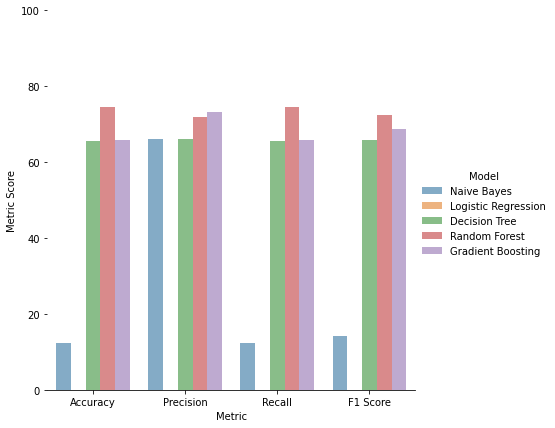

In [ ]:
data_metrics = get_metric_data([[NB_metrics,LG_metrics,DT_metrics,RF_metrics, GB_metrics]], '')
plot_metric_graph(data_metrics)

Error Analysis

In [7]:
# Random Forest
RF.fit(x_train, y_train)
RF_pred = RF.predict(x_test)

data_compare = test
data_compare['predicted'] = RF_pred

KeyboardInterrupt: 

In [ ]:
random_forest_errors = data_compare[data_compare['label'] != data_compare['predicted']]

In [ ]:
from matplotlib import pyplot as plt
import altair as alt

def show_distribution_graph(df, column):
    df = df[column].value_counts().to_frame()
    df = df.reset_index().rename(columns={"index": "Classe", column: "Frequência"})

    return alt.Chart(df).mark_bar().encode(
        x=alt.X('Classe', sort='-y'),
        y='Frequência',
        color = alt.value("#ac97b4")
    )

In [ ]:
random_forest_errors.groupby(by='label').count().sort_values(by='label')['bg_number']

label
DUPLICATE     854
FIXED         387
INACTIVE       41
INCOMPLETE    378
INVALID       377
MOVED           7
WONTFIX       510
WORKSFORME    818
Name: bg_number, dtype: int64

In [ ]:
show_distribution_graph(random_forest_errors, 'label')

alt.Chart(...)

Looking for better parameter

In [ ]:
NB_tuned_metrics, nb_pred = get_tuned_metrics(NB, "Naive Bayes", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(NB_tuned_metrics, open('./data/models/NB_tuned_metrics.pkl', 'wb'))
pickle.dump(nb_pred, open('./data/models/nb_pred.pkl', 'wb'))

In [ ]:
LG_tuned_metrics, lg_pred = get_tuned_metrics(LG, "Logistic Regression", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(LG_tuned_metrics, open('./data/models/LG_tuned_metrics.pkl', 'wb'))
pickle.dump(lg_pred, open('./data/models/lg_pred.pkl', 'wb'))

In [ ]:
DT_tuned_metrics, dt_pred = get_tuned_metrics(DT, "Decision Tree", 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(DT_tuned_metrics, open('./data/models/DT_tuned_metrics.pkl', 'wb'))
pickle.dump(dt_pred, open('./data/models/dt_pred.pkl', 'wb'))

In [ ]:
RF_tuned_metrics, rf_pred = get_tuned_metrics(RF, 'RandomForest', 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(RF_tuned_metrics, open('./data/models/RF_tuned_metrics.pkl', 'wb'))
pickle.dump(rf_pred, open('./data/models/rf_pred.pkl', 'wb'))


KeyboardInterrupt



In [ ]:
GB_tuned_metrics, gb_pred = get_tuned_metrics(GB, 'Gradient Boosting', 10, x_train, y_train, x_test, y_test, classes)
pickle.dump(GB_tuned_metrics, open('./data/models/GB_tuned_metrics.pkl', 'wb'))
pickle.dump(gb_pred, open('./data/models/gb_pred.pkl', 'wb'))

# FURTHER ANALYSIS

RANDOM FOREST

In [ ]:
RF.fit(x_train, y_train)
pred = RF.predict(x_test)

In [ ]:
# Print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred, labels=classes)

classes_total = y_test.value_counts()
result = f'Error Analysis \n'
for index, classx in enumerate(classes):
    result += f'\nClasse: {classx} \n'
    partial = ''
    right_class = ''

    for i, value in enumerate(confusion_matrix[index]):
        percentage = round((value/classes_total[classx]) * 100, 2)
        if (classx == classes[i]):
            right_class = f'   The model preditecd right {value} - {percentage}%'
        else:
            partial += f'   {classes[i]}: {value} - {percentage}% \n'
    result += f'{right_class} \n'
    result += partial 
print(result)

Error Analysis 

Classe: INCOMPLETE 
   The model preditecd right 334 - 46.91% 
   FIXED: 107 - 15.03% 
   DUPLICATE: 82 - 11.52% 
   INVALID: 8 - 1.12% 
   WONTFIX: 25 - 3.51% 
   WORKSFORME: 156 - 21.91% 
   INACTIVE: 0 - 0.0% 
   MOVED: 0 - 0.0% 

Classe: FIXED 
   The model preditecd right 8101 - 95.44% 
   INCOMPLETE: 19 - 0.22% 
   DUPLICATE: 161 - 1.9% 
   INVALID: 13 - 0.15% 
   WONTFIX: 44 - 0.52% 
   WORKSFORME: 150 - 1.77% 
   INACTIVE: 0 - 0.0% 
   MOVED: 0 - 0.0% 

Classe: DUPLICATE 
   The model preditecd right 456 - 34.81% 
   INCOMPLETE: 44 - 3.36% 
   FIXED: 485 - 37.02% 
   INVALID: 25 - 1.91% 
   WONTFIX: 54 - 4.12% 
   WORKSFORME: 246 - 18.78% 
   INACTIVE: 0 - 0.0% 
   MOVED: 0 - 0.0% 

Classe: INVALID 
   The model preditecd right 75 - 16.59% 
   INCOMPLETE: 13 - 2.88% 
   FIXED: 132 - 29.2% 
   DUPLICATE: 106 - 23.45% 
   WONTFIX: 24 - 5.31% 
   WORKSFORME: 102 - 22.57% 
   INACTIVE: 0 - 0.0% 
   MOVED: 0 - 0.0% 

Classe: WONTFIX 
   The model preditecd right 218

CLASSES JOINT

Classes:
1 - fixed
2 - moved and inactive
3 - wontfix, incomplete and invalid
4 - worksforme

In [ ]:
train_new_classes = train.copy()
test_new_classes = test.copy()

In [ ]:
train_new_classes['label'] = train_new_classes['label'].replace(['MOVED', 'INACTIVE'], 'INACTIVE')
train_new_classes['label'] = train_new_classes['label'].replace(['WONTFIX', 'DUPLICATE'], 'IGNORED')
train_new_classes['label'] = train_new_classes['label'].replace(['INCOMPLETE', 'WORKSFORME', 'INVALID'], 'INCOMPLETE')


In [ ]:
test_new_classes['label'] = test_new_classes['label'].replace(['MOVED', 'INACTIVE'], 'INACTIVE')
test_new_classes['label'] = test_new_classes['label'].replace(['WONTFIX', 'DUPLICATE'], 'IGNORED')
test_new_classes['label'] = test_new_classes['label'].replace(['INCOMPLETE', 'WORKSFORME', 'INVALID'], 'INCOMPLETE')

In [ ]:
x_train_new_classes = train_new_classes.drop('label', axis=1)
x_test_new_classes = test_new_classes.drop('label', axis=1)
y_train_new_classes = train_new_classes['label']

Executing Random Forest with the new classes

In [ ]:
RF_new_classes = RandomForestClassifier(random_state=42)

In [ ]:
RF_metrics_new_classes = get_metrics(RF_new_classes, "Random Forest", x_train_new_classes, y_train_new_classes, x_test_new_classes, y_test_new_classes, classes_new_classes)

/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predicted

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'WONTFIX'

FEATURES IMPORTANCE

In [ ]:
RF_new_features = RandomForestClassifier(random_state=42)

/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Random Forest Metrics:

Accuracy score is:	74.46%
Precision score is:	71.81%
Recall score is:	74.46%
F1 score is:	72.32%


[[ 456  485    0   44   25    0   54  246]
 [ 161 8101    0   19   13    0   44  150]
 [   5   15    1    2    1    0    2   16]
 [  82  107    0  334    8    0   25  156]
 [ 106  132    0   13   75    0   24  102]
 [   3    2    0    0    0    0    0    2]
 [  96  261    0   18    9    0  218  126]
 [ 233  432    1   70   18    0   64  645]]


/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_home/manel_local/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   DUPLICATE       0.40      0.35      0.37      1310
       FIXED       0.85      0.95      0.90      8488
    INACTIVE       0.50      0.02      0.05        42
  INCOMPLETE       0.67      0.47      0.55       712
     INVALID       0.50      0.17      0.25       452
       MOVED       0.00      0.00      0.00         7
     WONTFIX       0.51      0.30      0.38       728
  WORKSFORME       0.45      0.44      0.44      1463

    accuracy                           0.74     13202
   macro avg       0.48      0.34      0.37     13202
weighted avg       0.72      0.74      0.72     13202



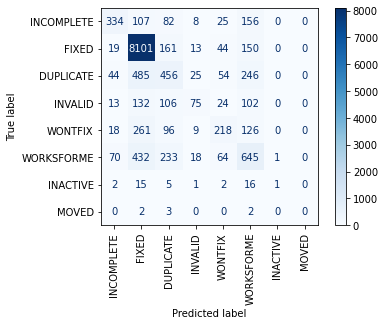

In [ ]:
RF_metrics_new_features = get_metrics(RF_new_features, "Random Forest", x_train, y_train, x_test, y_test, classes)

In [ ]:
feature_names = [f"feature {i}" for i in range(x_train.shape[1])]
RF_new_features.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

# RANDOM FOREST EVALUATION

In [14]:
RF = RandomForestClassifier(random_state=42)
fit_result = RF.fit(x_train, y_train)
pred = RF.predict(x_test)

KeyboardInterrupt: 

In [9]:
data = test.copy()
data['predicted'] = pred

In [10]:
def eval_classification(row):
    if ((row['label'] == row['predicted']) & (row['label'] == 'FIXED')):
        return 'right'
    elif ((row['label'] != row['predicted']) & (row['label'] == 'FIXED')):
        return 'wrong'
    else:
        return 'other'


data['classification'] = data.apply(lambda row: eval_classification(row), axis=1)
data.head()

,bg_number,total_users_commenting,total_comments_by_author,has_attachment,total_attachment_comments,changes_severity,changes_priority,changes_assigned,total_changes,total_users_changes,...,op_sys_Other,op_sys_Solaris,op_sys_Unspecified,op_sys_Windows,op_sys_Windows Phone 8,op_sys_iOS,op_sys_macOS,label,predicted,classification
0,990833.0,0,3,False,0,0,1,1,9,2,...,0,0,0,0,0,0,0,WONTFIX,WONTFIX,other
1,1713606.0,6,0,False,3,0,1,1,20,7,...,0,0,1,0,0,0,0,FIXED,FIXED,right
2,1338477.0,1,0,False,2,0,1,1,9,3,...,0,0,1,0,0,0,0,FIXED,FIXED,right
3,1032077.0,0,1,False,0,1,1,0,5,2,...,0,0,0,0,0,0,0,INVALID,WONTFIX,other
4,1124266.0,3,0,False,2,0,1,1,7,2,...,0,0,0,0,0,0,1,FIXED,FIXED,right


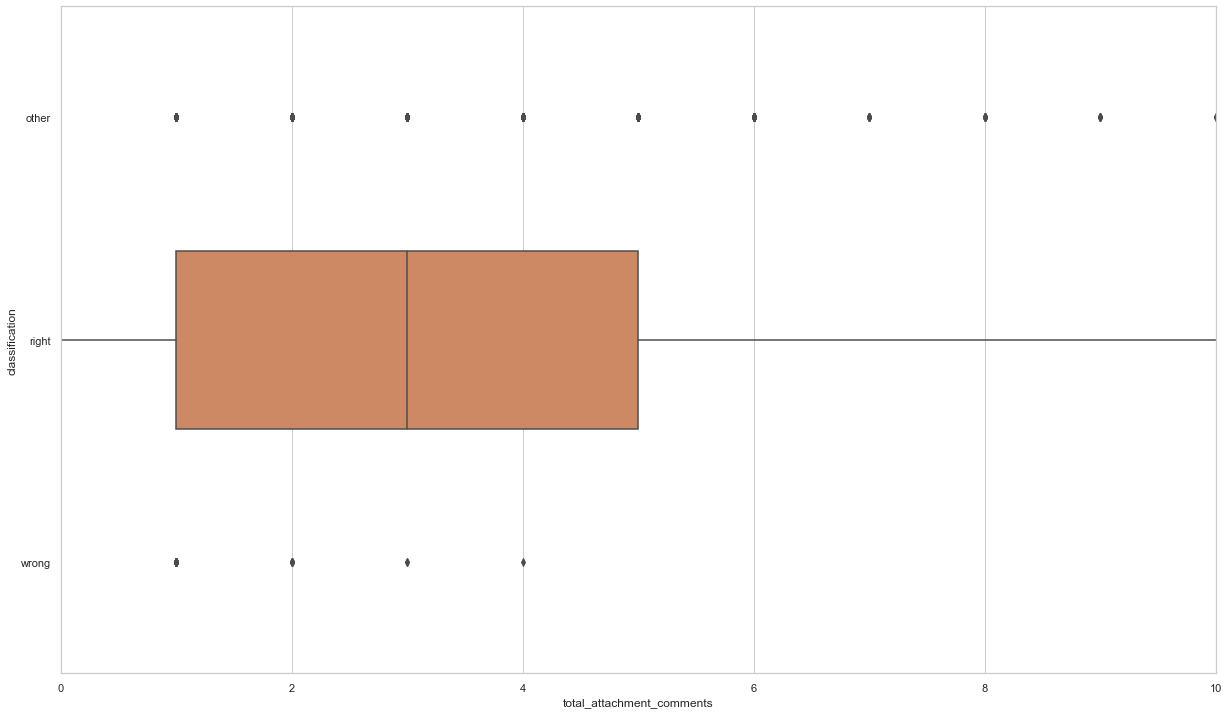

In [11]:
sns.set(rc={"figure.figsize":(20.7, 12.27)})
import matplotlib as mpl


sns.set_style('whitegrid')
ax= sns.boxplot(x='total_words_desc',y='classification',data=data).set(xlim=(0, 10))
#ax = sns.stripplot(x='total_changes',y='classification',data=data, edgecolor='red', linewidth=1, size=8,
#                   jitter=True, alpha=0.6)